In [1]:
import logging
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import math
import io
import gzip
import statsmodels.api as sm
from sklearn.decomposition import PCA
import scvi
import scipy as sp
import os
import anndata as ad
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, r2_score, f1_score
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge, LinearRegression
from matplotlib.colors import ListedColormap


import sys
import os
from contextlib import contextmanager

@contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        try:
            sys.stdout = devnull
            sys.stderr = devnull
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


In [19]:
def read_collate_10x(num_batches, path, prefix_recipe,ref_h5ad, batch_mismatch = False, batch_skip = []):
    # Read in the data
    adata_list = []
    #iterate from 1 to number of batches

    #split the reference indices by "-" and keep the first elements
    ref_h5ad.obs['barcode_nogem'] = ref_h5ad.obs.index.str.split("-").str[0]

    

    #loop through the batches excluding the ones in batch_skip
    for i in range(1,num_batches+1):
        if i in batch_skip:
            print("Skipping batch ", i)
            continue
        print(i)
        adata = sc.read_10x_mtx(path = path, prefix = prefix_recipe(i))
        #create a var variable gene_name with the current indices
        adata.var['gene_name'] = adata.var.index

        #set the index to be the gene_ids
        adata.var.index = adata.var['gene_ids']

        

        #split the indices by "-" and keep the first elements
        adata.obs['barcode_nogem'] = adata.obs.index.str.split("-").str[0]

        #if batch_mismatch  = False, subset reference intuitively
        if batch_mismatch == False:
            adata.obs['gem_group'] = i
            ref_h5ad_subset = ref_h5ad[ref_h5ad.obs['gem_group'] == i]
            index = i

        #if batch_mismatch = True
        if batch_mismatch:
            batch_counts = ref_h5ad.obs[ref_h5ad.obs['barcode_nogem'].isin(adata.obs['barcode_nogem'])]['gem_group'].value_counts()
            #what is the batch with the highest count?
            max_batch = batch_counts.idxmax()
            #what proportion of batch_counts are from the max_batch?
            max_prop = batch_counts.max()/batch_counts.sum()
            print("Maximum batch: ", max_batch)
            print("Proportion for maximum batch: ", max_prop)
            
            #if max_prop > 0.5, then we will subset the reference to only include cells from the max_batch
            if max_prop > 0.3:
                ref_h5ad_subset = ref_h5ad[ref_h5ad.obs['gem_group'] == max_batch]
                index = max_batch
                adata.obs['gem_group'] = index

            #otherwise, throw an error
            else:
                raise ValueError("Ambiguous batch mismatch detected")


        #print the fraction of cells in the reference, using 'barcode_nogem'
        print(adata.obs['barcode_nogem'].isin(ref_h5ad_subset.obs['barcode_nogem']).sum()/adata.obs.shape[0])

        #print the fraction of reference cells with gem_group == i in the data
        print(ref_h5ad_subset.obs['barcode_nogem'].isin(adata.obs['barcode_nogem']).sum()/ref_h5ad_subset.obs.shape[0])

    

        #retain only the cells that are in the reference, using 'barcode_nogem'
        adata = adata[adata.obs['barcode_nogem'].isin(ref_h5ad_subset.obs['barcode_nogem'])]
        
        #change the index to be BARCODE-i rather than BARCODE-1 using the 'index' variable
        adata.obs.index = adata.obs['barcode_nogem'] + "-" + str(index)

      #  print(adata.obs.head())

        adata_list.append(adata)
    adata = ad.concat(adata_list)

    #what fraction of reference cells are in the data
    print(ref_h5ad.obs['barcode_nogem'].isin(adata.obs['barcode_nogem']).sum()/ref_h5ad.obs.shape[0])
    
    #reorder the cells in the data to match the reference
    adata = adata[ref_h5ad.obs.index,:]

    return adata

In [3]:
#Load in the highly preprocessed, filtered K562 Essential data
K562_adata_preprocess = sc.read('/home/t-ajaynadig/perturbation_project/data/weissman_perturbseq/K562_essential_raw_singlecell_01.h5ad')



In [4]:
def K562_prefix(i):
    return "KD6_" + str(i) + "_essential_"

K562_mex_path = "/home/t-ajaynadig/perturbation_project/ldvae_hematopoietic/training_data_raw/K562_essential_other/"

K562_adata_mex = read_collate_10x(48,
                                  K562_mex_path,
                                  K562_prefix,
                                  K562_adata_preprocess)


#does obs match between the two datasets?
print(K562_adata_preprocess.obs.index.equals(K562_adata_mex.obs.index))





1
0.558176224658831
2
0.555357971238596
3
0.540031049013085
4
0.5450791465932553
5
0.540523138832998
6
0.5416577118704778
7
0.5452420449404313
8
0.5491666060120824
9
0.5257046826063708
10
0.5192334989354151
11
0.5235807214665879
12
0.5106145251396648
13
0.5275080906148867
14
0.5092466976079971
15
0.5208871662360034
16
0.5214831429172215
17
0.548828125
18
0.5440452159870811
19
0.5451145395044413
20
0.5427771176370735
21
0.1592663267921734
22
0.5399361022364217
23
0.5416395045632334
24
0.5417443855853167
25
0.5616290811174689
26
0.5541791153537856
27
0.552833078101072
28
0.5535662720184811
29
0.5484512428298279
30
0.5536646406864497
31
0.5491261373306278
32
0.5512308966347964
33
0.510250569476082
34
0.5129280223619846
35
0.5221859937624043
36
0.5256020575169511
37
0.5199175257731958
38
0.5240057043257804
39
0.5044391206313416
40
0.5106848515790241
41
0.4928919182083739
42
0.4999669508890211
43
0.5051221961834617
44
0.4996477384810483
45
0.4971763683753258
46
0.5025005138042064
47
0.51044

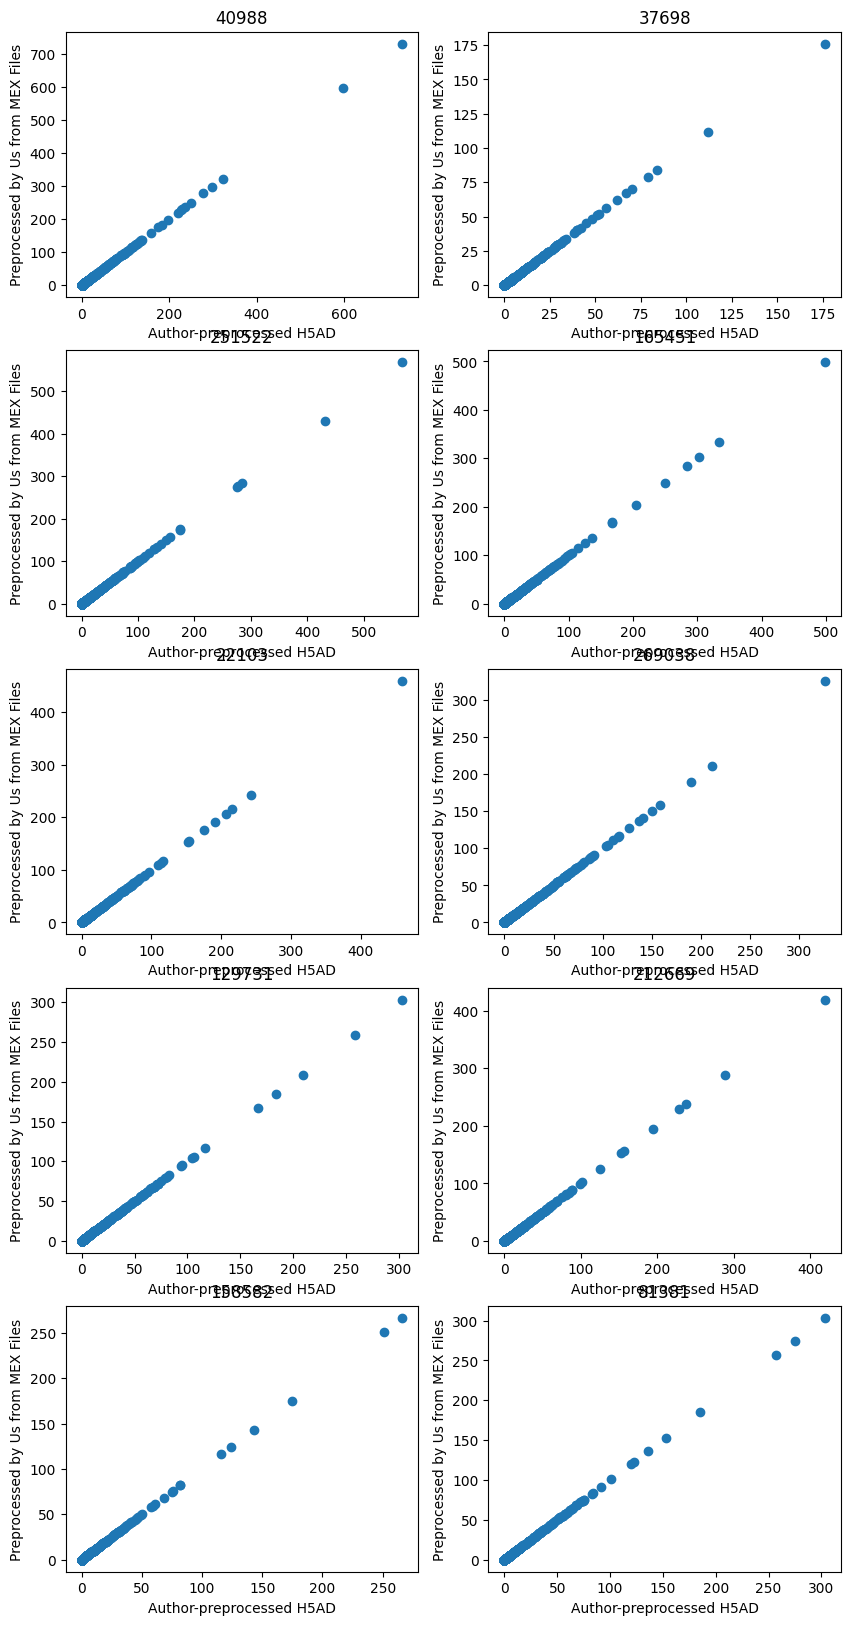

In [19]:
#set the mex obs to be the same as the preprocessed obs
K562_adata_mex.obs = K562_adata_preprocess.obs

#for a few random cells, plot the gene expression in the two datasets for the overlapping genes
#choose 10 random cells
np.random.seed(0)
random_cells_indices = np.random.choice(K562_adata_preprocess.shape[0], 10, replace=False)

#find the overlapping genes
overlapping_genes = K562_adata_preprocess.var.index.intersection(K562_adata_mex.var.index)


#plot the gene expression for the overlapping genes
fig, axs = plt.subplots(5,2, figsize=(10,20))
axs = axs.ravel()
for i, cell in enumerate(random_cells_indices):
    axs[i].scatter(K562_adata_preprocess[:,overlapping_genes].X[cell,:], K562_adata_mex[:,overlapping_genes].X[cell,:].toarray())
    axs[i].set_title(cell)
    axs[i].set_xlabel("Author-preprocessed H5AD")
    axs[i].set_ylabel("Preprocessed by Us from MEX Files")

plt.tight_layout()
plt.show()

In [20]:
#write out the data
K562_adata_mex.write("/home/t-ajaynadig/perturbation_project/ldvae_hematopoietic/training_data_raw/K562_essential_raw_singlecell_01_mex_collated.h5ad")

In [3]:
# Load in the highly preprocessed, filtered Jurkat Essential data
Jurkat_adata_preprocess = sc.read('/home/t-ajaynadig/perturbation_project/ldvae_hematopoietic/training_data_raw/GSE264667_jurkat_raw_singlecell_01.h5ad')

In [21]:
Jurkat_mex_path = "/home/t-ajaynadig/perturbation_project/ldvae_hematopoietic/training_data_raw/Jurkat_HepG2_MEX/"


def Jurkat_prefix(i):
    #get all the files in Jurkat_mex_path
    files = os.listdir(Jurkat_mex_path)

    #find the filename that contains jurkat_i
    jurkat_file = [file for file in files if "jurkat_" + str(i) + "_" in file][0]
    
    #remove everything following the third _
    return jurkat_file[:jurkat_file.find("_", jurkat_file.find("_", jurkat_file.find("_")+1)+1)] + "_"


Jurkat_adata_mex = read_collate_10x(56,
                                  Jurkat_mex_path,
                                  Jurkat_prefix,
                                  Jurkat_adata_preprocess,
                                  batch_mismatch = True,
                                  batch_skip = [47])

#does obs match between the two datasets?
print(Jurkat_adata_preprocess.obs.index.equals(Jurkat_adata_mex.obs.index))

1
Maximum batch:  11
Proportion for maximum batch:  0.8636986301369863
0.4431558601300299
1.0
2
Maximum batch:  22
Proportion for maximum batch:  0.8558923650510618
0.44481887110362256
1.0
3
Maximum batch:  33
Proportion for maximum batch:  0.8597014925373134
0.432
1.0
4
Maximum batch:  44
Proportion for maximum batch:  0.8576795260800463
0.43058174960104456
1.0
5
Maximum batch:  52
Proportion for maximum batch:  0.8086324598106144
0.30009807126511934
1.0
6
Maximum batch:  53
Proportion for maximum batch:  0.8521531100478469
0.43648394738991914
1.0
7
Maximum batch:  54
Proportion for maximum batch:  0.8560767590618337
0.43452380952380953
1.0
8
Maximum batch:  55
Proportion for maximum batch:  0.8668386264710624
0.42926712438128695
1.0
9
Maximum batch:  56
Proportion for maximum batch:  0.855675227837614
0.41527945315641335
1.0
10
Maximum batch:  1
Proportion for maximum batch:  0.5886925795053004
0.10111677591648459
1.0
11
Maximum batch:  2
Proportion for maximum batch:  0.854730258014

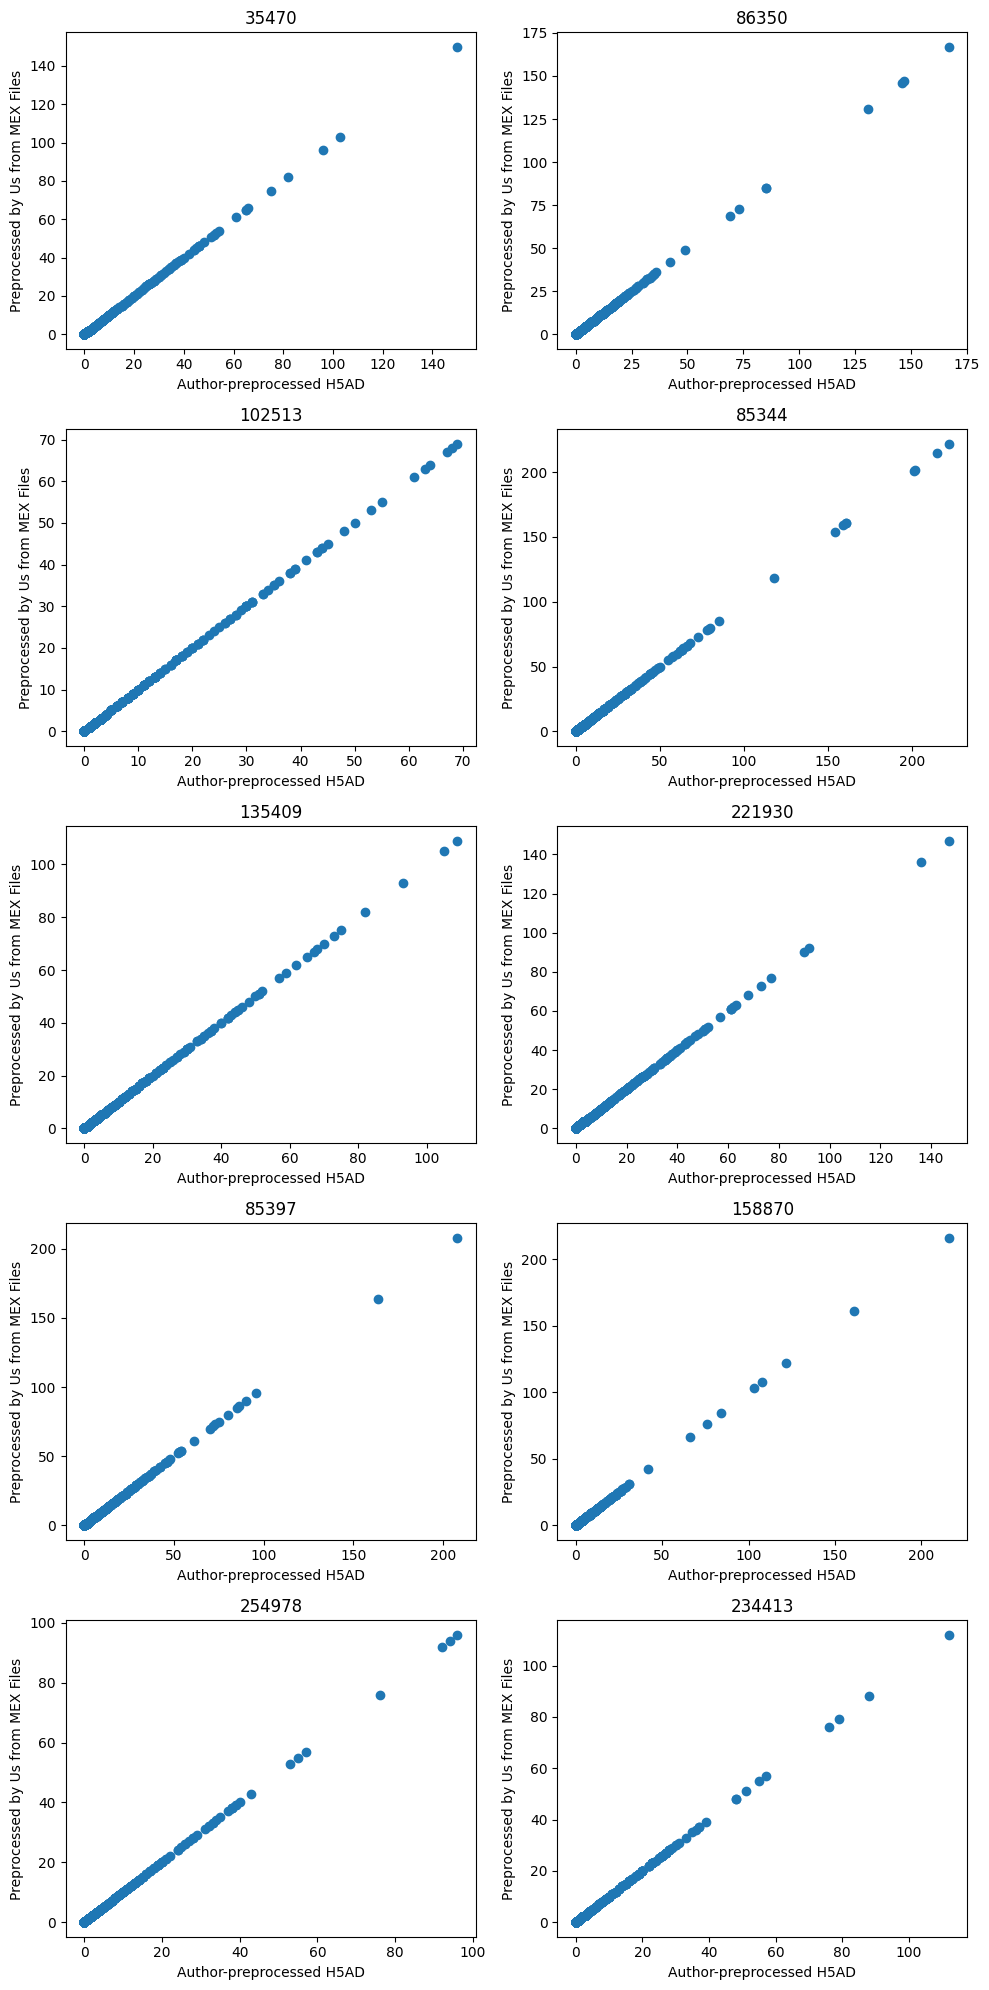

In [22]:
#set the mex obs to be the same as the preprocessed obs
Jurkat_adata_mex.obs = Jurkat_adata_preprocess.obs

#for a few random cells, plot the gene expression in the two datasets for the overlapping genes
#choose 10 random cells
np.random.seed(0)
random_cells_indices = np.random.choice(Jurkat_adata_preprocess.shape[0], 10, replace=False)

#find the overlapping genes
overlapping_genes_jurkat = Jurkat_adata_preprocess.var.index.intersection(Jurkat_adata_mex.var.index)


#plot the gene expression for the overlapping genes
fig, axs = plt.subplots(5,2, figsize=(10,20))
axs = axs.ravel()
for i, cell in enumerate(random_cells_indices):
    axs[i].scatter(Jurkat_adata_preprocess[:,overlapping_genes_jurkat].X[cell,:], Jurkat_adata_mex[:,overlapping_genes_jurkat].X[cell,:].toarray())
    axs[i].set_title(cell)
    axs[i].set_xlabel("Author-preprocessed H5AD")
    axs[i].set_ylabel("Preprocessed by Us from MEX Files")

plt.tight_layout()
plt.show()


In [23]:
# Write out the data
Jurkat_adata_mex.write("/home/t-ajaynadig/perturbation_project/ldvae_hematopoietic/training_data_raw/GSE264667_jurkat_raw_singlecell_01_mex_collated.h5ad")

In [14]:
adata = sc.read_10x_mtx(path = Jurkat_mex_path, prefix = Jurkat_prefix(47))

#make a new obs variable barcode_nogem, which is the barcode without the gem group
adata.obs['barcode_nogem'] = adata.obs.index.str.split("-").str[0]

#add a similar obs field to the reference
Jurkat_adata_preprocess.obs['barcode_nogem'] = Jurkat_adata_preprocess.obs.index.str.split("-").str[0]

#get the reference cells with matching barcode_nogem and look at the distribution of gem groups
batch_counts = Jurkat_adata_preprocess.obs[Jurkat_adata_preprocess.obs['barcode_nogem'].isin(adata.obs['barcode_nogem'])]['gem_group'].value_counts()
print(batch_counts)
print(batch_counts.idxmax())

gem_group
51    3461
24      36
38      32
47      31
4       30
31      29
40      29
7       29
2       27
28      27
16      26
53      26
48      26
5       26
22      26
3       26
43      26
30      26
21      25
35      25
42      25
55      24
8       24
26      23
44      23
14      23
17      23
29      23
13      23
25      22
15      22
49      22
56      21
19      21
20      20
32      20
34      20
10      20
46      19
6       19
33      19
45      18
23      18
18      18
27      18
11      18
52      18
39      17
54      17
37      16
9       15
36      14
12      14
1        9
50       3
Name: count, dtype: int64
51


In [17]:
#print out gem_group value counts for Jurkat_adata_preprocess sorted by gem_group
print(Jurkat_adata_preprocess.obs['gem_group'].value_counts().sort_index())

gem_group
1     1666
2     5466
3     5847
4     5349
5     5618
6     4835
7     5743
8     4386
9     4152
10    4633
11    5044
12    5711
13    5061
14    4900
15    4080
16    5243
17    4650
18    4326
19    4435
20    4586
21    5086
22    5280
23    4873
24    5232
25    5517
26    4859
27    4048
28    4188
29    5467
30    5196
31    4879
32    4240
33    5184
34    5112
35    4494
36    3457
37    4173
38    5023
39    5237
40    4902
42    5076
43    4723
44    5936
45    4588
46    4716
47    5498
48    4916
49    5098
50     870
51    4983
52    3672
53    5343
54    4818
55    5377
56    5164
Name: count, dtype: int64
